In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner
import os

from scipy import optimize
from scipy.stats import poisson

import jax
import jax.numpy as jnp

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../utils/matplotlibrc')

from utils import ed_fcts as ef

In [2]:
# load SVI fit results (these should be the only parameters that you are loading)
gpu_id = '0'

# sim name
sim_name = 'canon_g1'

# load SVI fit results (these should be the only parameters that you are loading)
sim_id = 7.1234567
temp_id = 7.1234567
gp_id = 0
blg_id = -1
mod_id = -1
svi_id = -131
sim_seed = 0
svi_seed = 0

In [3]:
# load GPU
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

data_dir = ef.load_data_dir(sim_name)
os.system("mkdir -p "+data_dir)

# Load the simulated templates
## NOTE: This information should already be taken into account once
## specifying the relevant IDs ; however, this is a good way to double-check
## you're loading what you want
ebin = 10

temp_dict = np.load(data_dir + 'all_templates_ebin' + str(ebin)  + '.npy', allow_pickle=True).item()

In [4]:
fit_filename, module_name = ef.generate_fit_filename_from_ids(sim_id, temp_id, gp_id, blg_id, mod_id, svi_id, sim_seed, svi_seed)
fit_dir = data_dir + 'fits/' + fit_filename + '/'
ef.list_files(fit_dir)

sys.path.append(fit_dir)
import importlib 
module = importlib.import_module(module_name)

# Load all the variables from the module
globals().update(vars(module))

file_name = ('ebin' + str_ebin + '_smp_svi_' + 
             str_lr + '_' + str_n_steps + '_' + 
                str_guide + '_' + str_num_particles + '_' + 
                str_sim_seed + '_' + str_svi_seed + '.p')

if is_gp:
   samples, svi_results, gp_samples = pickle.load(open(fit_dir + file_name, 'rb'))
else:
   samples, svi_results = pickle.load(open(fit_dir + file_name, 'rb'))

ModuleNotFoundError: No module named 'settings_7p1234567_7p1234567_0_-1_-1_-131_0_0'

In [17]:
from models.poissonian_ed import EbinPoissonModel # to set GPU at the beginning

ebinmodel = EbinPoissonModel(
        # all parameters
        rig_temp_list = rig_temp_list,
        hyb_temp_list = hyb_temp_list,
        var_temp_list = var_temp_list,
        is_gp = is_gp,
        gp_deriv = gp_deriv,
        data_file = data_file,
        rig_temp_sim = rig_temp_sim,
        hyb_temp_sim = hyb_temp_sim,
        var_temp_sim = var_temp_sim,
        is_custom_blg= is_custom_blg,
        custom_blg_id = custom_blg_id,
        sim_seed = sim_seed,
        Nu = Nu,
        u_option = u_option,
        u_grid_type = u_grid_type,
        u_weights = u_weights,
        Np = Np,
        p_option = p_option,
        Nsub = Nsub,
        ebin = ebin,
        is_float64 = is_float64,
        debug_nans = debug_nans,
        no_ps_mask = no_ps_mask,
        p_grid_type = p_grid_type,
        p_weights = p_weights,
        gp_kernel = gp_kernel,
        gp_params = gp_params,
        gp_scale_option = gp_scale_option,
        monotonicity_hyperparameter = monotonicity_hyperparameter,
        nfw_gamma =  nfw_gamma,
        )
ebinmodel.config_model(ebin=ebin)

In [ ]:
nside = ebinmodel.nside
mask = ebinmodel.mask_roi_arr[ebin]

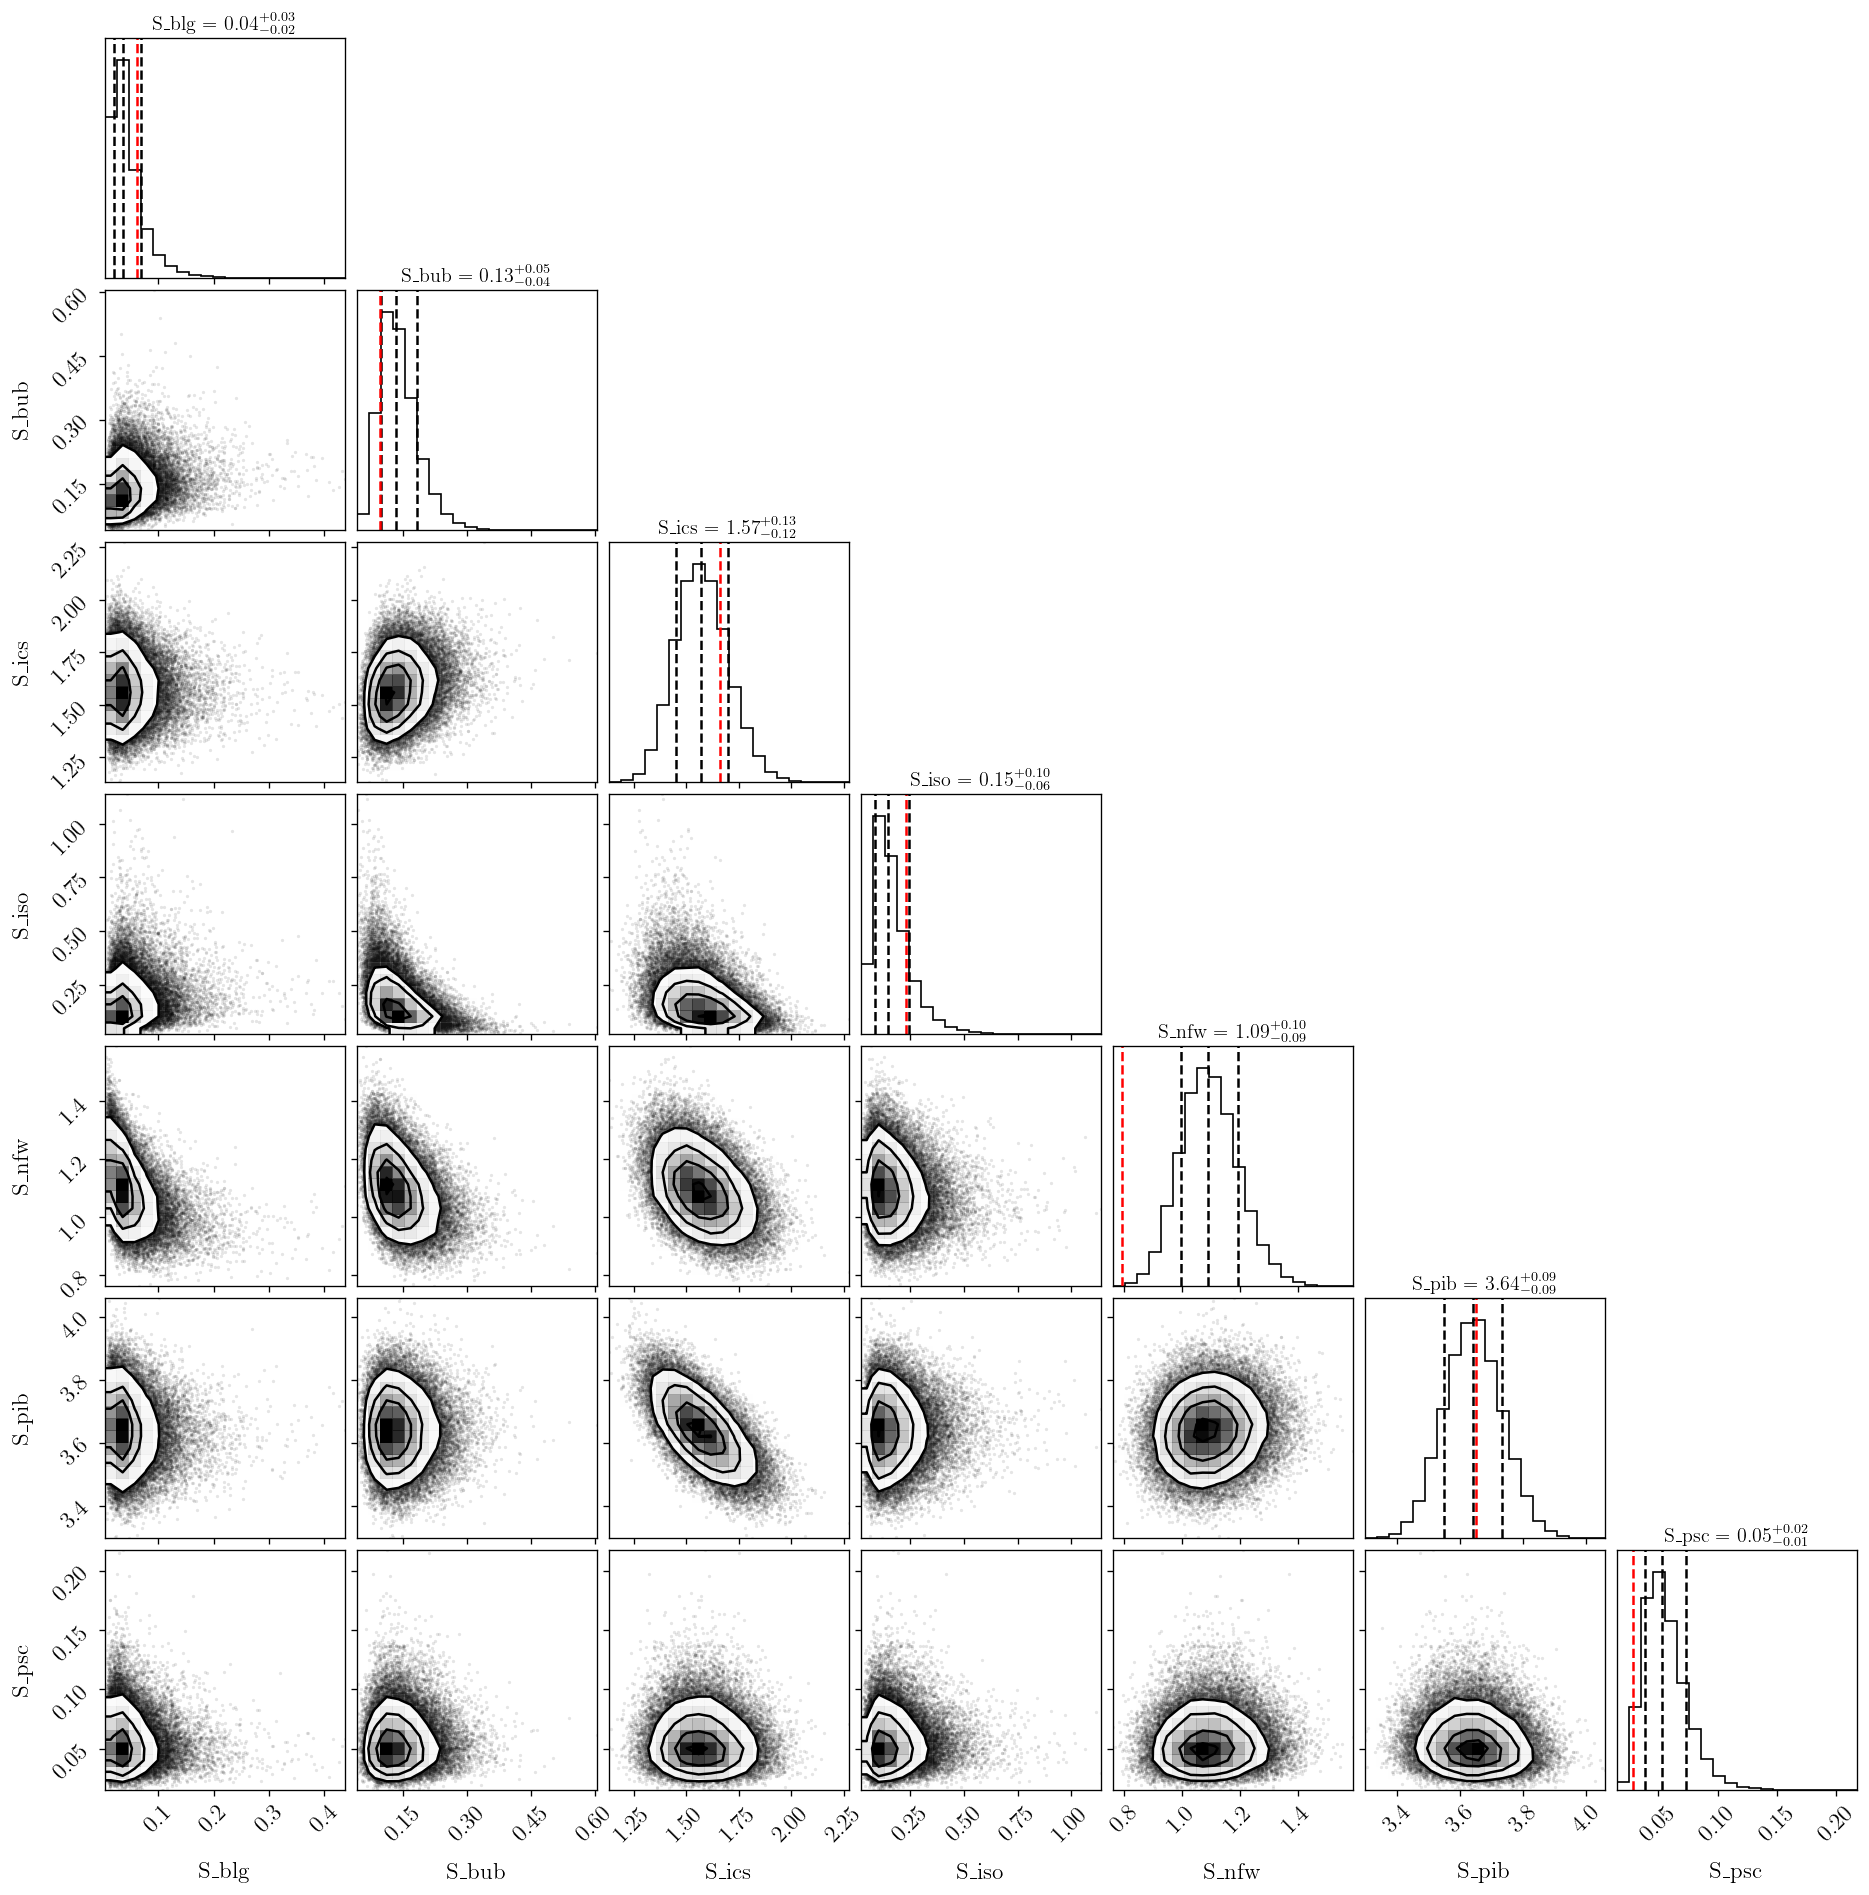

In [ ]:
if is_custom_blg: # adding line here to not override all_templates dict
    temp_blg = np.load(data_dir + 'custom_blg_' + str(custom_blg_id) + '.npy', allow_pickle = True)[~mask]
    temp_dict['blg'] = temp_blg
# generate corner plots of samples
ef.make_corner_plots(samples, with_mean_vlines = False, sim_vlines = True, temp_dict = temp_dict, with_log_rate_u = False)

In [9]:
# generate samples and plot histograms of log counts

temp_names_sim = rig_temp_sim + hyb_temp_sim + var_temp_sim # imported from settings file
temp_sample_dict = ef.generate_temp_sample_maps(samples, ebinmodel, gp_samples = None, custom_num=1000, nfw_gamma=nfw_gamma)

iso
psc
bub
pib


100%|██████████| 1000/1000 [00:01<00:00, 769.83it/s]


ics


100%|██████████| 1000/1000 [00:01<00:00, 928.90it/s]


blg


100%|██████████| 1000/1000 [00:01<00:00, 896.76it/s]


nfw


100%|██████████| 1000/1000 [00:03<00:00, 309.27it/s]


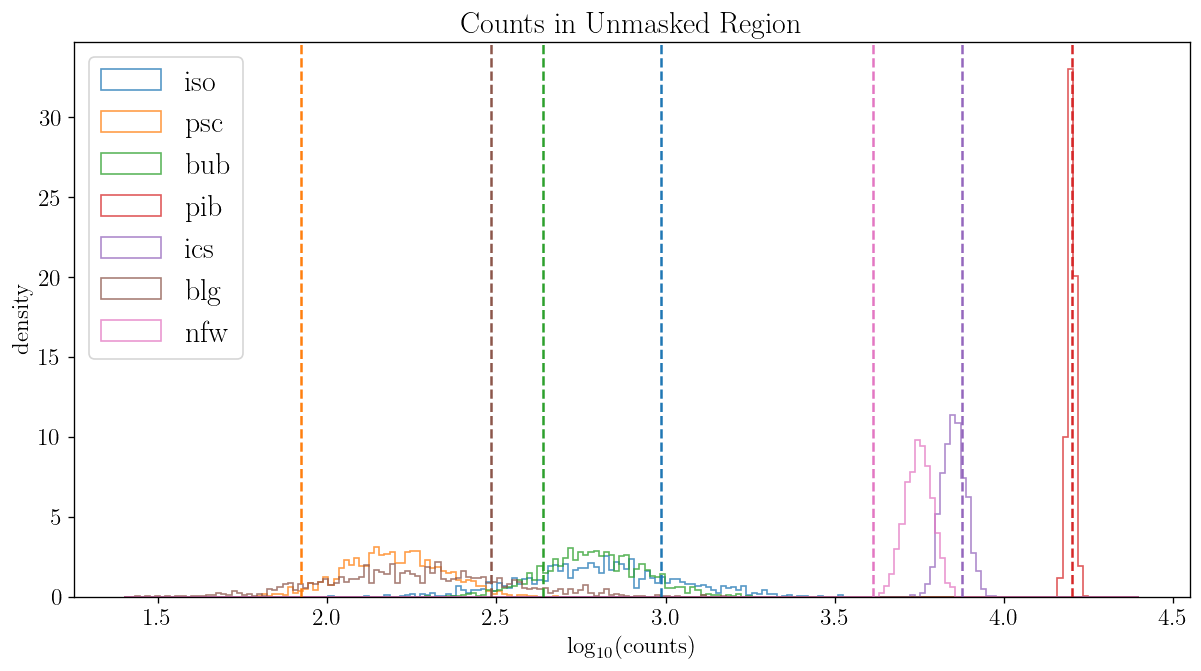

In [10]:
ef.tot_log_counts_hist(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(1.4,4.4,200), gp_model_nfw=False)

In [11]:
from likelihoods.pll_jax import log_like_poisson

# compute the Poisson LL
data = ebinmodel.counts[10][~mask]
data = data[np.newaxis]
# tot_ll = 0
tot_temp = jnp.zeros((1000,data.shape[1]))
names = list(temp_sample_dict.keys())

for name in names:
    temp_sample = temp_sample_dict[name]
    tot_temp += temp_sample

ll = log_like_poisson(tot_temp, data) # can't obtain for all templates
ll_avg = ll.mean()

print(ll_avg)

-2.298123


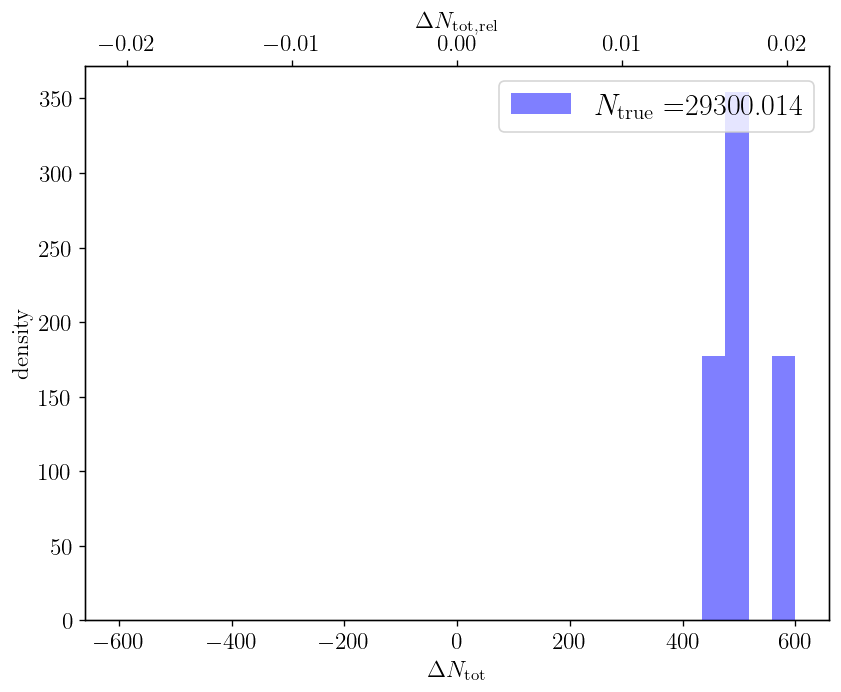

In [16]:
from utils import ed_fcts as ef
ef.tot_counts_hist_all_temps(temp_sample_dict, temp_dict, temp_names_sim, bins = np.linspace(-600,600,30))

In [15]:
from utils import ed_fcts as ef

# take quantiles of samples
Nx1, Nx2, x1_plt, x2_plt, x1_c, x2_c, x = ef.cart_coords()

exp_gp_samples = np.exp(gp_samples)
exp_gp_samples_cart = ef.multi_healpix_to_cart(exp_gp_samples, mask, n_pixels=80, nside = 128)
q = np.percentile(exp_gp_samples_cart, [16,50,84], axis = 0)

sim_cart = ef.healpix_to_cart(temp_dict['blg'] + temp_dict['nfw'], mask, n_pixels=80, nside = 128)
raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

NameError: name 'gp_samples' is not defined

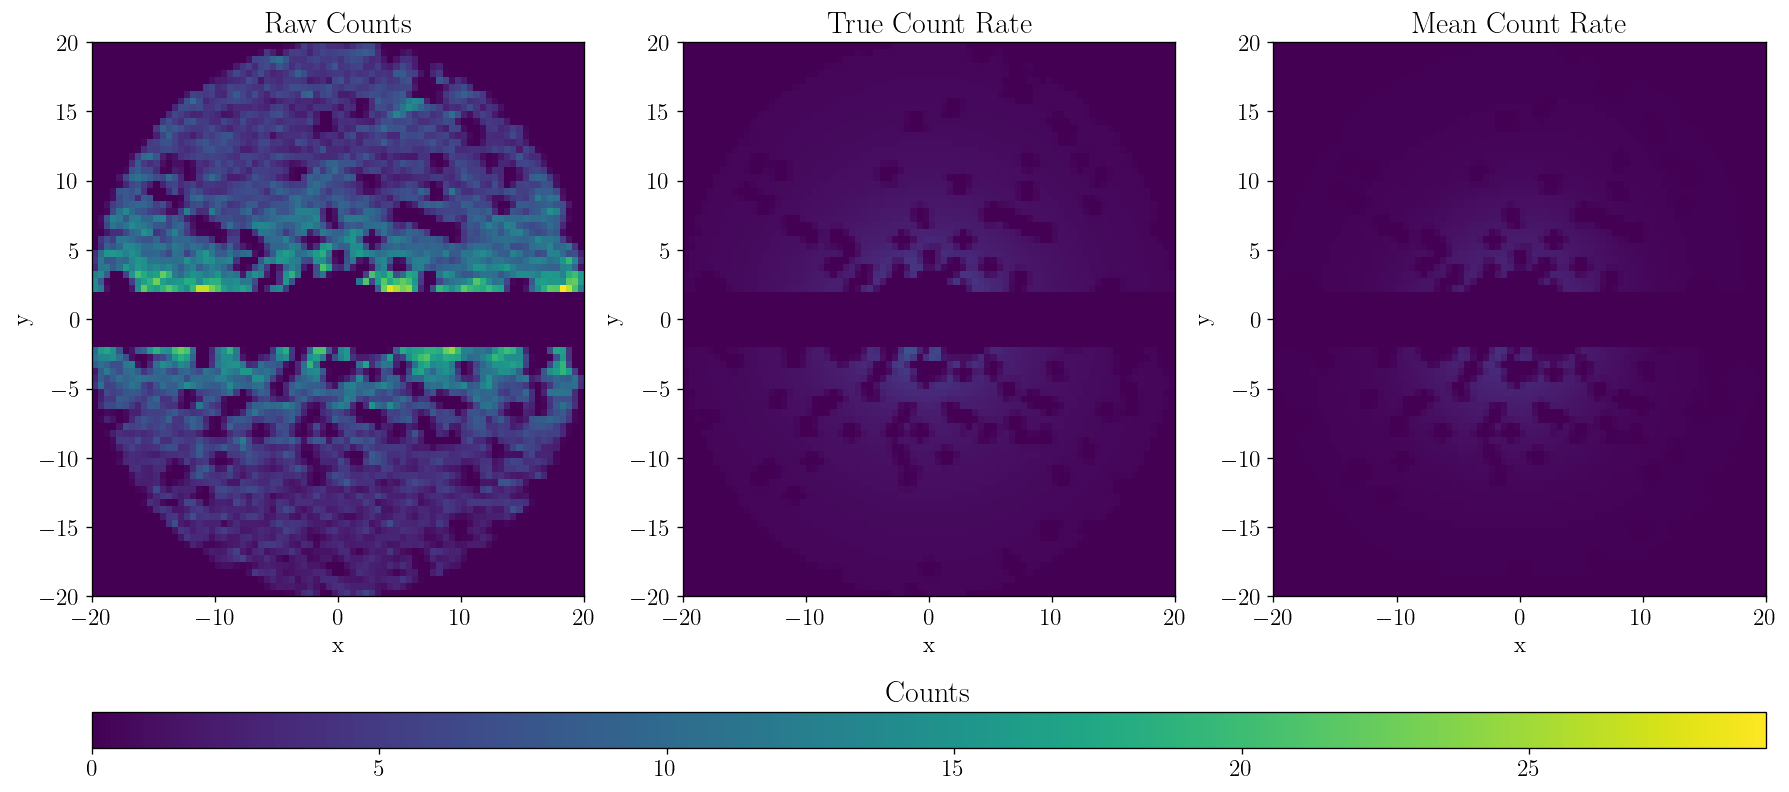

In [ ]:
from utils import ed_fcts as ef

# plot raw count map, true rate map, and mean rate map from posterior of log_rate

ef.triple_cart_plot(x1_plt, x2_plt, raw_cart, sim_cart, q[1])

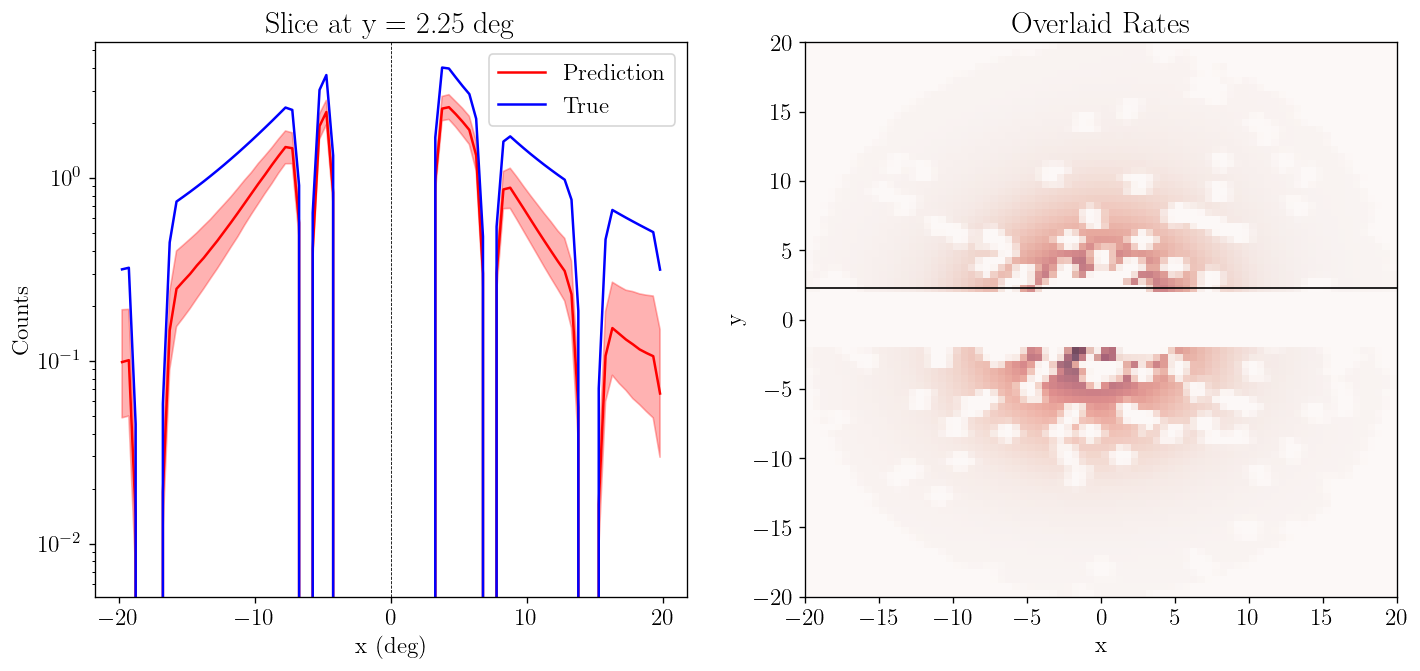

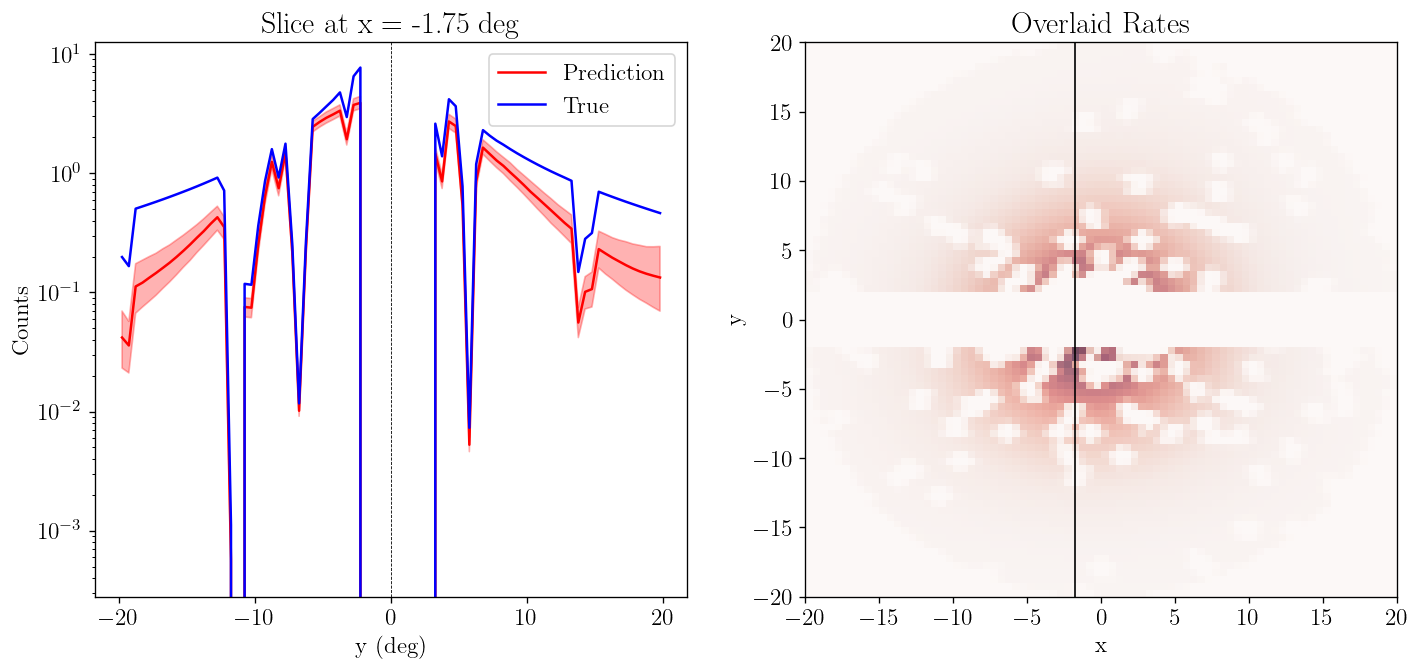

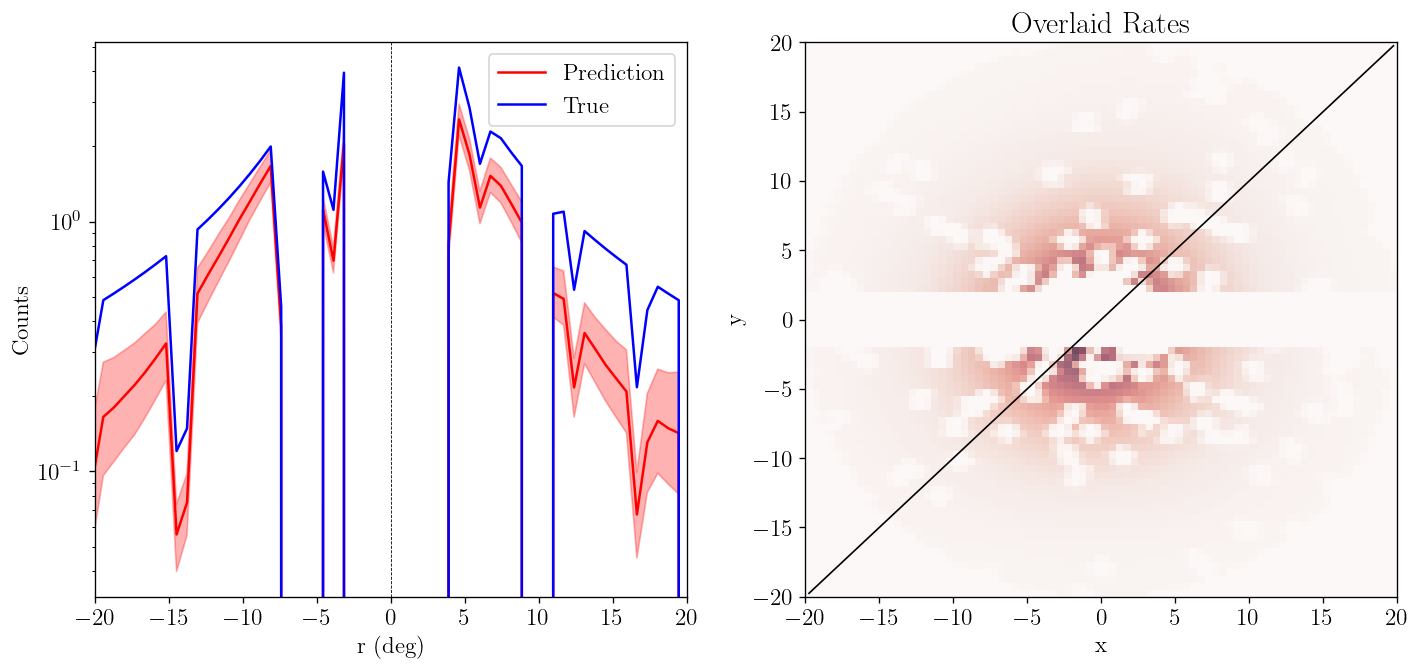

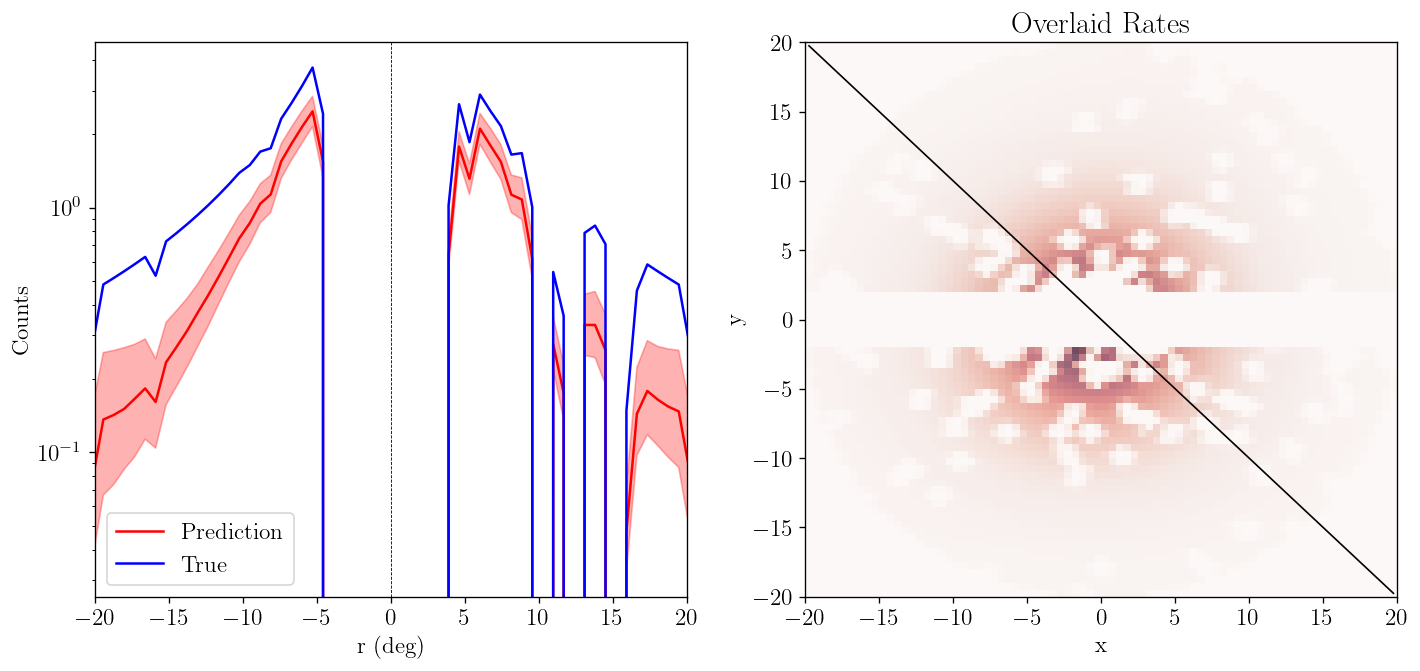

In [ ]:
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'vertical', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q, blg_coord=sim_cart, sim_coord=None, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)

In [ ]:
tot_samples = jnp.zeros(temp_sample_dict['gp'].shape)
tot_names = list(temp_sample_dict.keys())
for tot_name in tot_names:
    tot_samples += temp_sample_dict[tot_name]

tot_samples_cart = ef.multi_healpix_to_cart(tot_samples, mask, n_pixels=80, nside = 128)
q_tot = np.percentile(tot_samples_cart, [16,50,84], axis = 0)

sim_samples = jnp.zeros(temp_dict['blg'].shape)
for sim_name in temp_names_sim:
    sim_samples += temp_dict[sim_name]
sim_cart = ef.healpix_to_cart(sim_samples, mask, n_pixels=80, nside = 128)

raw_cart = ef.healpix_to_cart(ebinmodel.counts[ebin][~mask], mask, n_pixels=80, nside = 128)

100%|██████████| 1000/1000 [00:07<00:00, 125.85it/s]


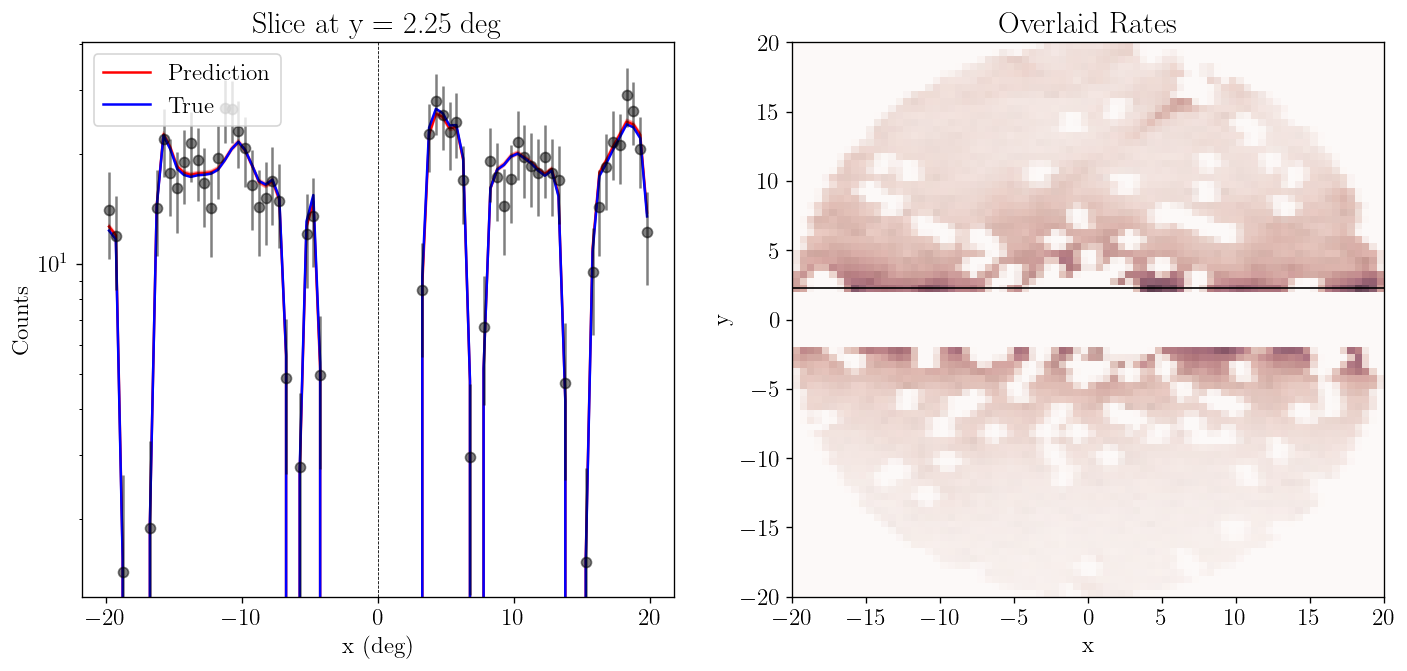

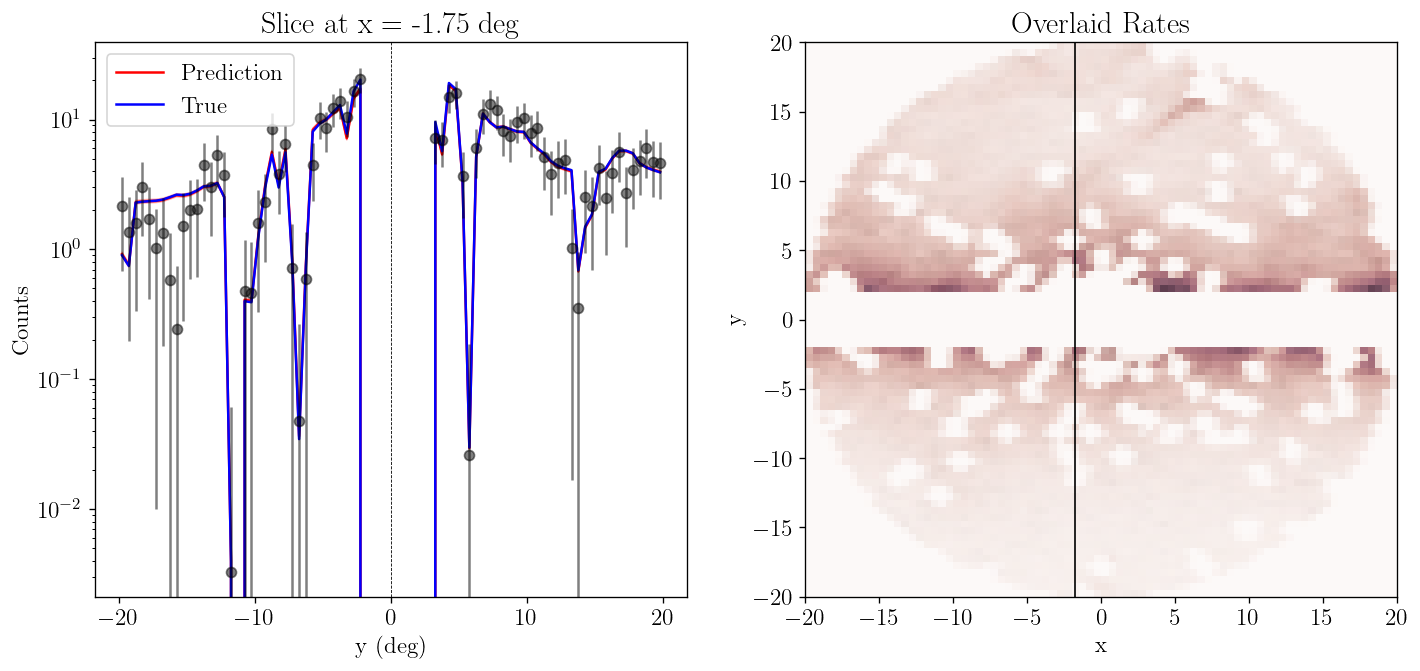

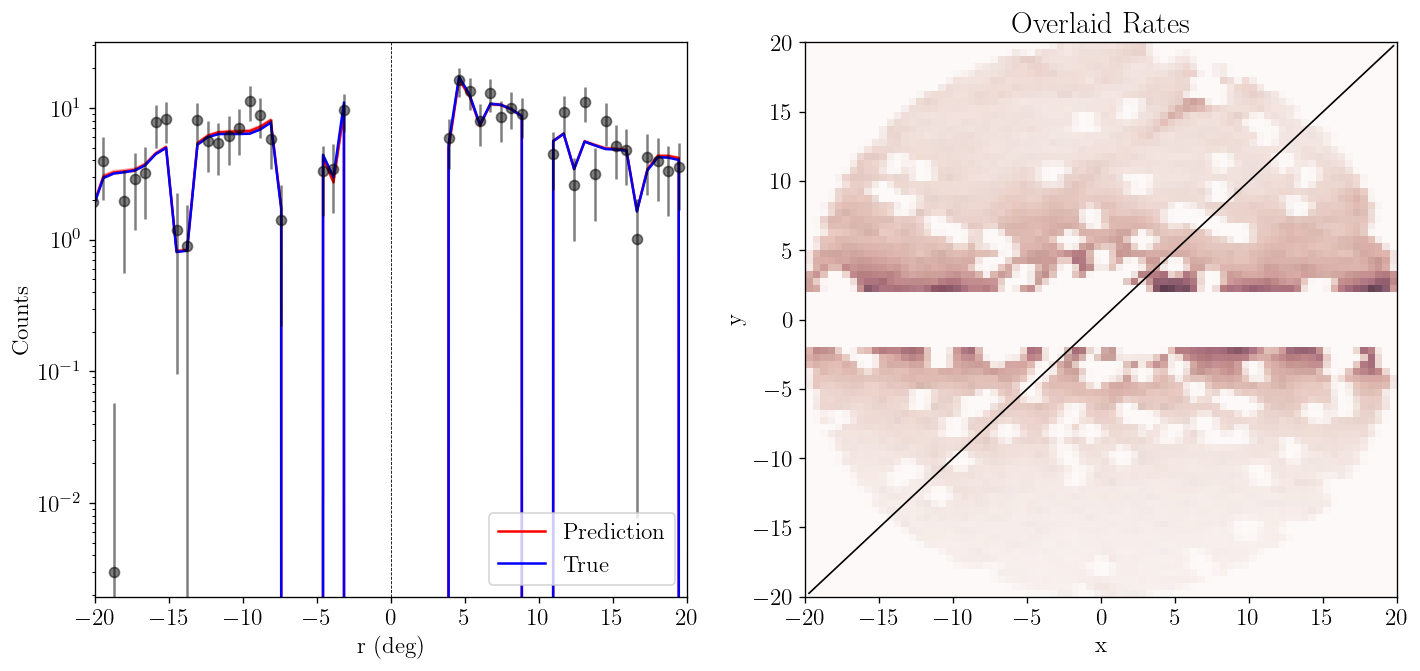

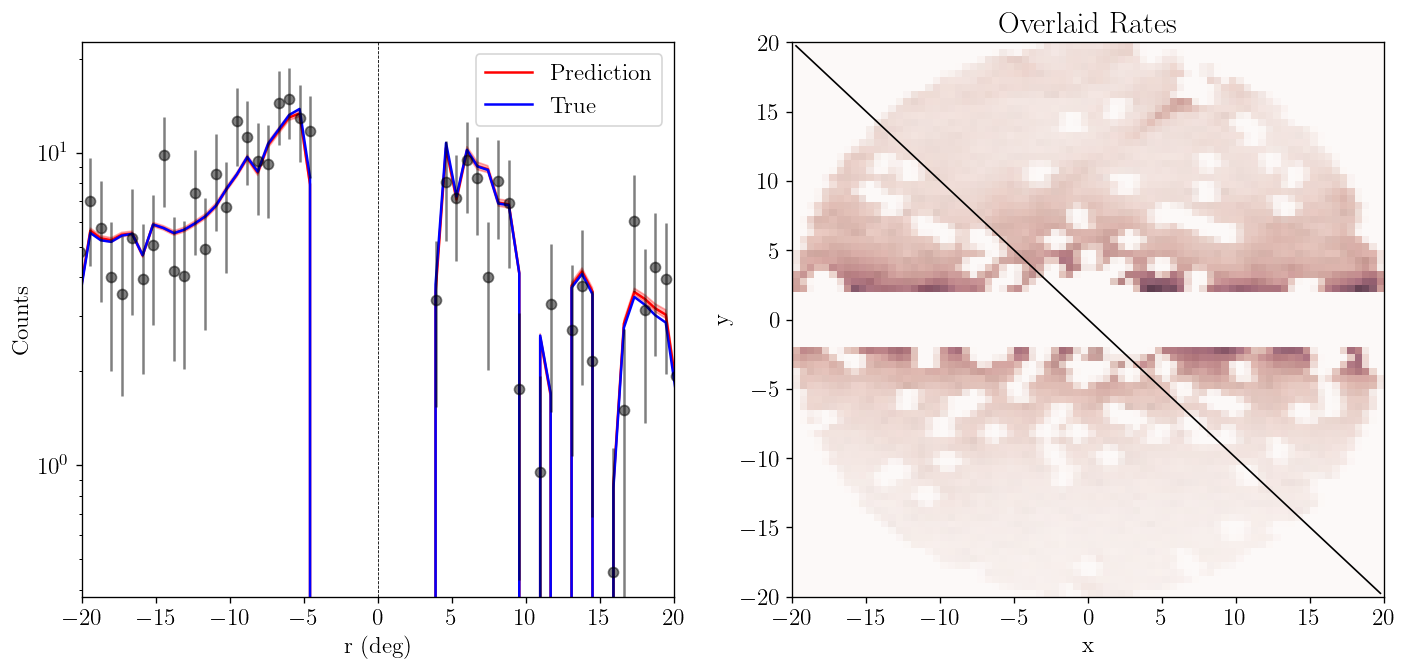

In [ ]:
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'horizontal', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'vertical', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'diagonal_up', slice_val = 2., res_scale = 1)
ef.cart_plot_1d(x, x1_plt, x2_plt, x1_c, x2_c, q_tot, sim_cart, raw_cart, slice_dir = 'diagonal_down', slice_val = 2., res_scale = 1)